In [58]:
import pandas as pd
import numpy as np
import warnings
from utils import utils_gn, utils_sevsn, utils_noah, utils_models
from sklearn.svm import NuSVR
import importlib
importlib.reload(utils_gn)
importlib.reload(utils_sevsn)
importlib.reload(utils_noah)
importlib.reload(utils_models)
warnings.filterwarnings('ignore')

In [59]:
# read the data
df_raw = (utils_gn.read_data('severson_all.pkl')).drop('cycle_life', axis=1).join(utils_gn.read_data('noah_all.pkl'))
df = df_raw.copy()
df.head()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
b1c0,-0.002873,-2.541602,0.000010,-5.014861,-0.008460,-2.072648,-0.532058,-0.274041,1.651688,0.217928,...,-0.005282,0.003144,-79.299389,-75.009448,-68.133388,11.166000,2.586119,0.000388,-0.000031,1851.0
b1c1,-0.004100,-2.387257,0.000010,-5.013960,-0.011004,-1.958457,-0.429375,-0.367163,1.970884,0.294661,...,0.001686,0.000501,-75.511329,-73.411862,-60.405989,15.105340,10.906407,0.000396,-0.000019,2159.0
b1c2,-0.004487,-2.348070,0.000018,-4.737000,-0.017216,-1.764058,-1.080194,0.033502,3.348637,0.524868,...,-0.005399,0.004043,-76.601709,-73.345940,-65.414446,11.187263,4.675725,0.000312,-0.000013,2236.0
b1c3,-0.007456,-2.127507,0.000036,-4.442613,-0.018961,-1.722149,-0.439050,-0.357486,1.904584,0.279800,...,-0.002219,0.012165,-80.446334,-67.731448,-55.749502,24.696832,-0.732940,0.000353,-0.000013,1433.0
b1c4,-0.005750,-2.240332,0.000023,-4.647744,-0.013958,-1.855177,-0.362548,-0.440634,1.666169,0.221719,...,0.002736,0.001597,-75.575598,-65.232594,-55.730088,19.845510,-0.840498,0.000347,-0.000030,1708.0


In [60]:
# prune cells with more than 1250 cycle life
df = df[df['cycle_life'] <= 1250]
df.index

Index(['b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16',
       'b1c17', 'b1c18',
       ...
       'b3c29', 'b3c30', 'b3c31', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41',
       'b3c43', 'b3c44'],
      dtype='object', length=113)

In [61]:
# define parameters for model pipeline
estimator = NuSVR()
param_grid = {"nu": [0.1, 0.3, 0.5, 0.7, 0.9],
              "C": [0.001, 0.01, 0.1, 1.0],
              "kernel": ["linear", "poly", "rbf", "sigmoid"]}
algo = utils_models.fit_nusvr
#title = 'Support Vector Regression'
fname = 'nusvr'

0 features removed from a total of 244
0 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.01 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 67.30530814787352,
 'MAPE': 0.09631358697186221,
 'MSE': 6226.230428123273,
 'R2 score': 0.8635660127712455,
 'RMSE': 78.90646632642519}
Test:
{'MAE': 65.30517116516057,
 'MAPE': 0.10220438326705207,
 'MSE': 6769.31660401846,
 'R2 score': 0.8763009334430377,
 'RMSE': 82.27585675043719}


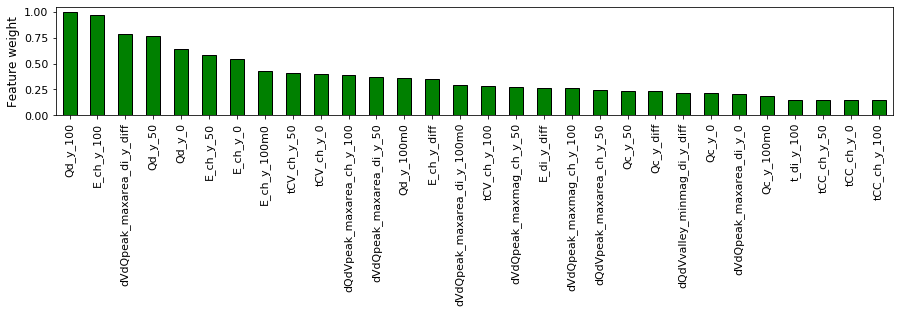

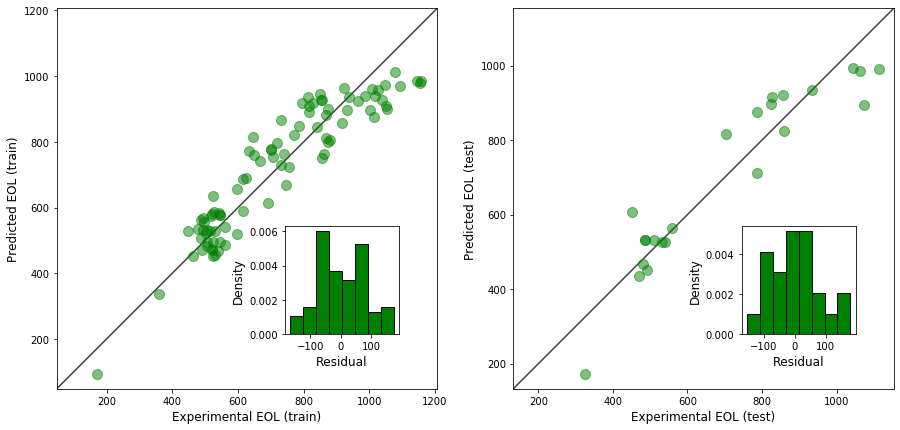

25 features removed from a total of 244
25 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.03 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 56.48882090332465,
 'MAPE': 0.074044344847857,
 'MSE': 5527.714935990581,
 'R2 score': 0.8788724256695302,
 'RMSE': 74.34860412940233}
Test:
{'MAE': 64.1549774422073,
 'MAPE': 0.10516007818919752,
 'MSE': 9440.19725089674,
 'R2 score': 0.8274946118849985,
 'RMSE': 97.16067749298962}


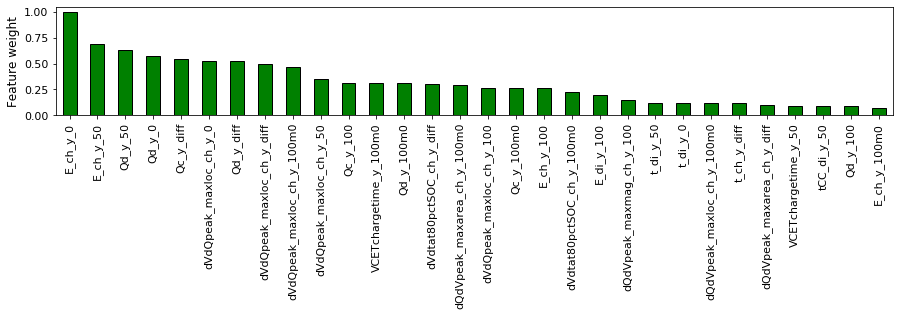

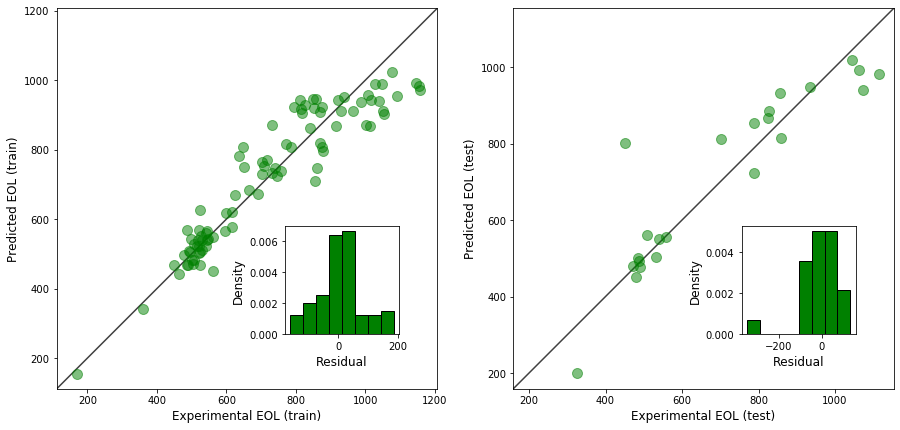

49 features removed from a total of 244
49 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.02 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 70.06102794271962,
 'MAPE': 0.10376712314541443,
 'MSE': 6508.422237136676,
 'R2 score': 0.8573824071190855,
 'RMSE': 80.67479307154544}
Test:
{'MAE': 82.02506597689907,
 'MAPE': 0.1361700486893284,
 'MSE': 9560.71367621994,
 'R2 score': 0.8252923557062267,
 'RMSE': 97.77890199945968}


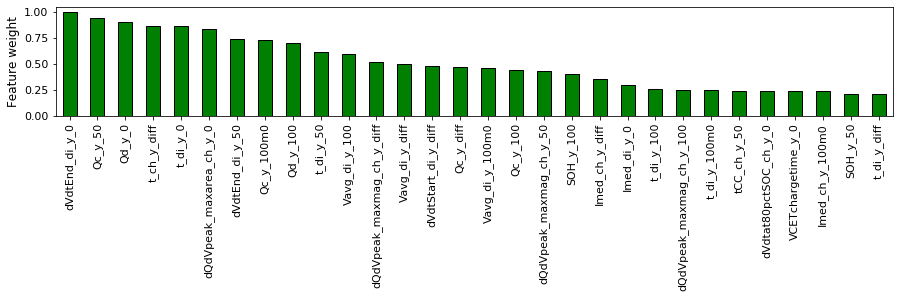

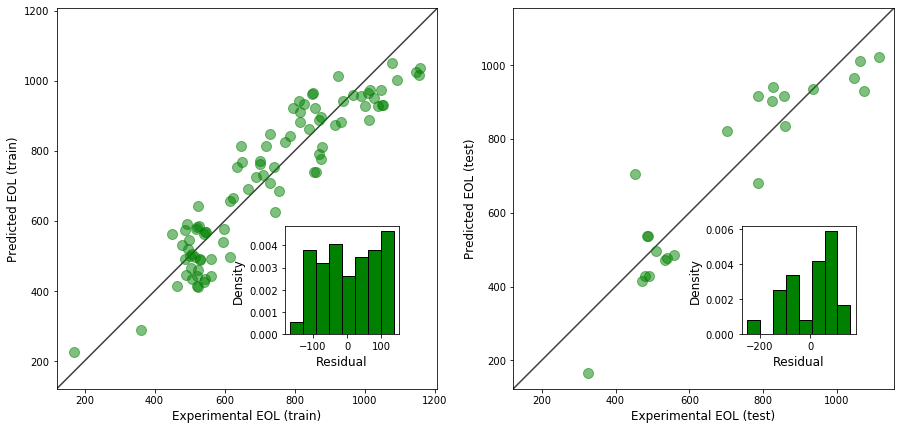

74 features removed from a total of 244
74 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.13 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 56.07276601657714,
 'MAPE': 0.07630418641646088,
 'MSE': 4939.631290363704,
 'R2 score': 0.8917589703490341,
 'RMSE': 70.2825105582015}
Test:
{'MAE': 75.67802090050843,
 'MAPE': 0.13174268066292932,
 'MSE': 14100.936585851627,
 'R2 score': 0.7423266194680103,
 'RMSE': 118.74736454276207}


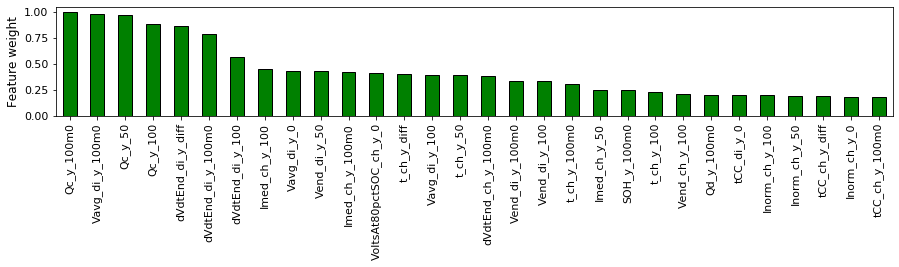

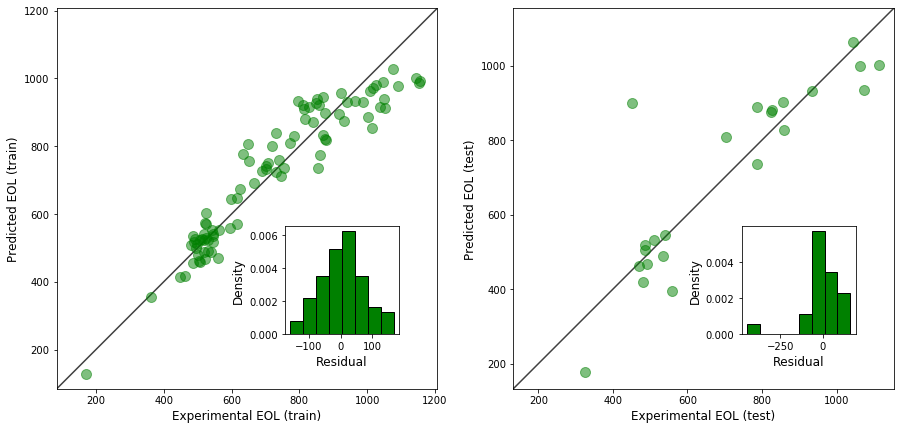

98 features removed from a total of 244
98 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.07 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 57.07588546425428,
 'MAPE': 0.07630962048599779,
 'MSE': 5405.826117631802,
 'R2 score': 0.8815433479361033,
 'RMSE': 73.5243233061808}
Test:
{'MAE': 68.56912867231522,
 'MAPE': 0.11366935624307987,
 'MSE': 9607.737222298809,
 'R2 score': 0.8244330712176416,
 'RMSE': 98.01906560612996}


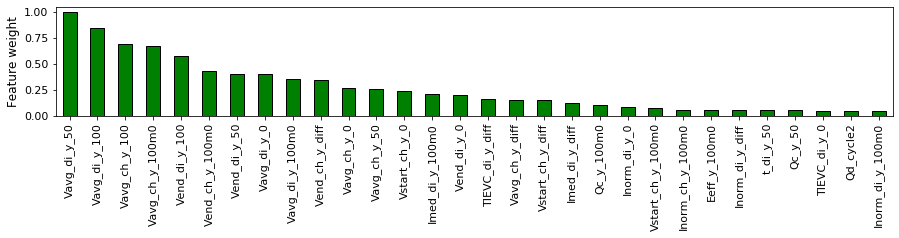

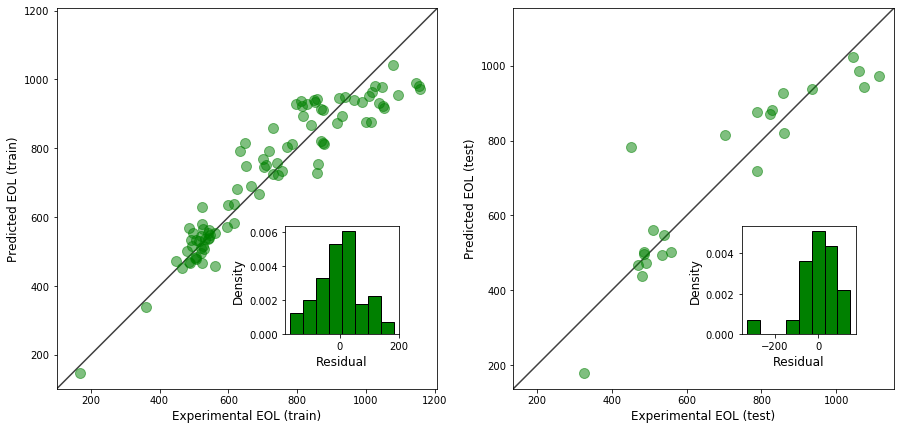

122 features removed from a total of 244
122 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.01 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 58.22213005416367,
 'MAPE': 0.075052726791221,
 'MSE': 6033.068793316435,
 'R2 score': 0.8677987202369513,
 'RMSE': 77.67283175806348}
Test:
{'MAE': 61.723069786283304,
 'MAPE': 0.0907595888067634,
 'MSE': 5998.771940113281,
 'R2 score': 0.8903814767594689,
 'RMSE': 77.4517394260018}


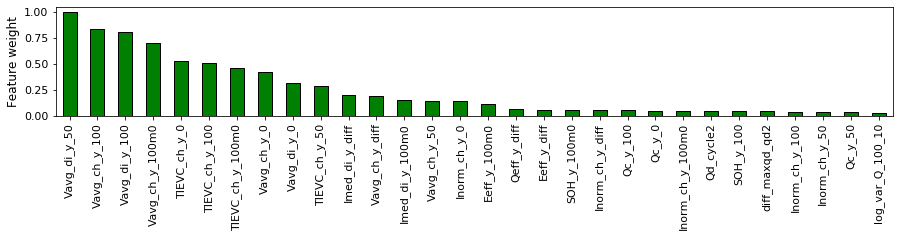

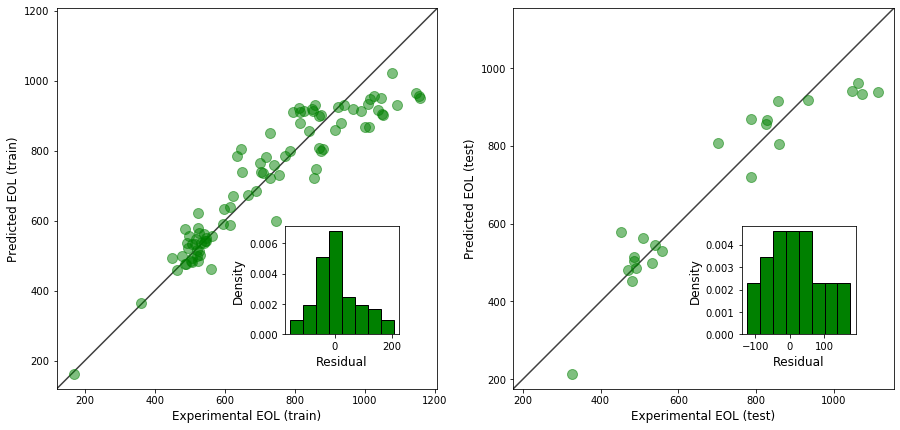

147 features removed from a total of 244
147 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.01 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 60.931914454007995,
 'MAPE': 0.08261490979039748,
 'MSE': 6125.914997029801,
 'R2 score': 0.8657642022540557,
 'RMSE': 78.26822469578444}
Test:
{'MAE': 60.5990273856451,
 'MAPE': 0.09193961069291208,
 'MSE': 5826.461460572214,
 'R2 score': 0.8935301912788282,
 'RMSE': 76.33126135845139}


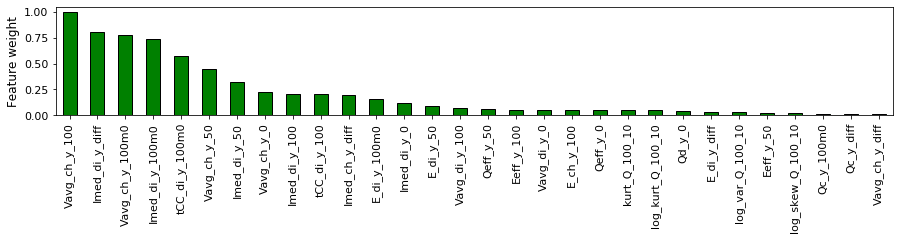

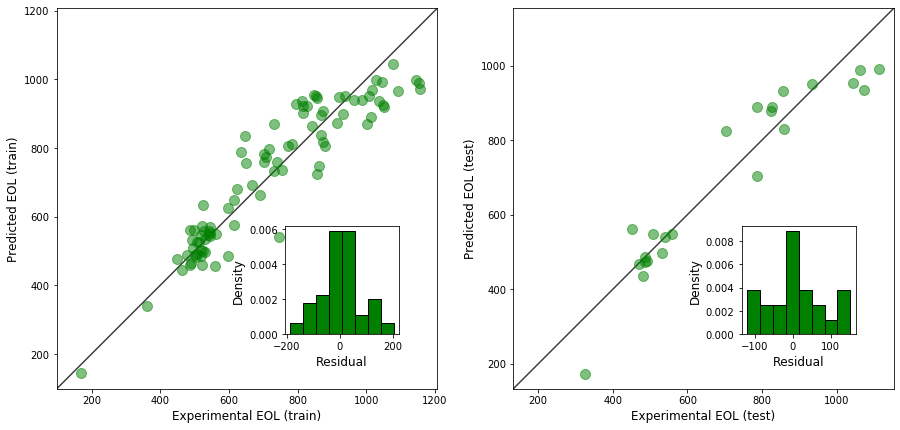

171 features removed from a total of 244
171 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.07 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 62.80277263440722,
 'MAPE': 0.08710709696568507,
 'MSE': 5696.160160438184,
 'R2 score': 0.8751813233458476,
 'RMSE': 75.47291010977504}
Test:
{'MAE': 66.2058293361871,
 'MAPE': 0.10326702059083784,
 'MSE': 7083.560956711505,
 'R2 score': 0.8705585911398499,
 'RMSE': 84.16389342652528}


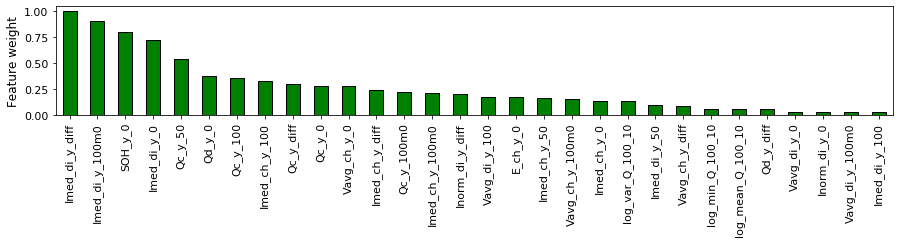

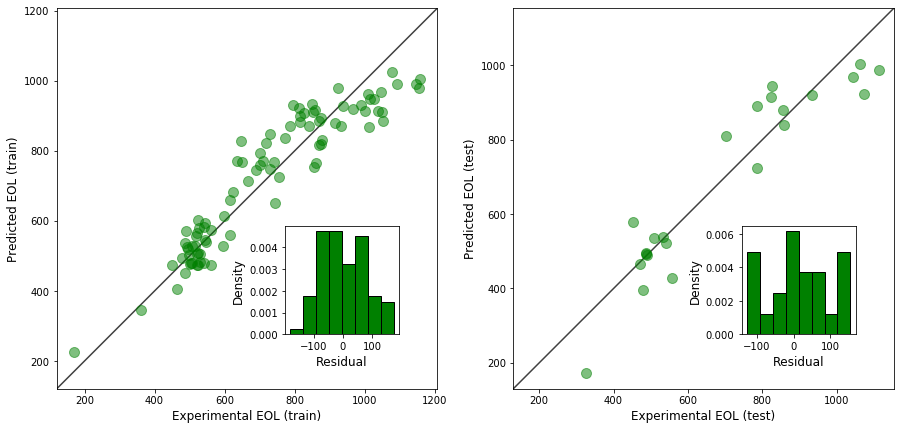

196 features removed from a total of 244
196 features removed from a total of 244
NuSVR training has started...
NuSVR training has ended after 0.07 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 60.22475842025451,
 'MAPE': 0.08238808999174574,
 'MSE': 6434.720950199056,
 'R2 score': 0.858997406845946,
 'RMSE': 80.21671241205947}
Test:
{'MAE': 71.64837101265648,
 'MAPE': 0.11519039064152778,
 'MSE': 7582.012601878977,
 'R2 score': 0.8614501379771782,
 'RMSE': 87.07475295330431}


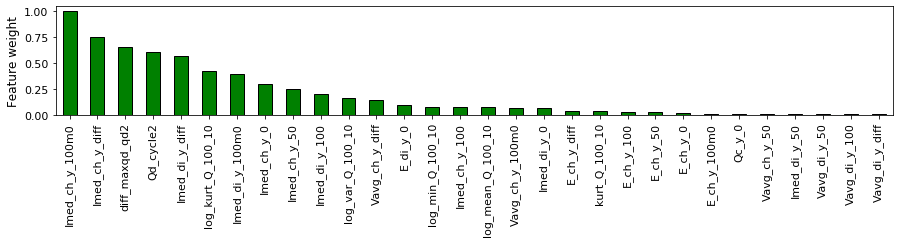

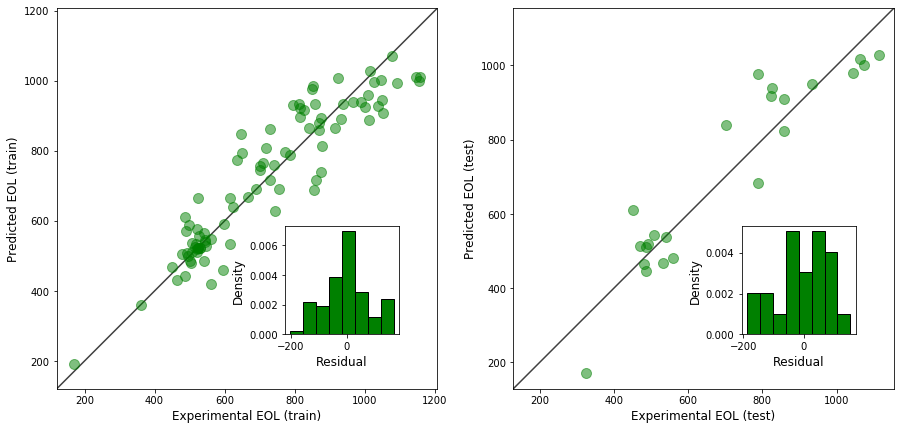

In [62]:
# call the model pipeline function
best_k, best_param, metrics = utils_models.model_pipeline(df=df,
                                                          algo=algo,
                                                          estimator=estimator,
                                                          param_grid=param_grid,
                                                          fname=fname)
                                                          #title=title)

In [63]:
best_k

0.5

In [64]:
best_param

{'C': 0.01, 'kernel': 'linear', 'nu': 0.9}

In [65]:
metrics

,Train_MAE,Train_MAPE,Train_MSE,Train_RMSE,Train_R2 score,Test_MAE,Test_MAPE,Test_MSE,Test_RMSE,Test_R2 score
Features used,,,,,,,,,,
1.0,67.305308,0.096314,6226.230428,78.906466,0.863566,65.305171,0.102204,6769.316604,82.275857,0.876301
0.9,56.488821,0.074044,5527.714936,74.348604,0.878872,64.154977,0.105160,9440.197251,97.160677,0.827495
0.8,70.061028,0.103767,6508.422237,80.674793,0.857382,82.025066,0.136170,9560.713676,97.778902,0.825292
0.7,56.072766,0.076304,4939.631290,70.282511,0.891759,75.678021,0.131743,14100.936586,118.747365,0.742327
0.6,57.075885,0.076310,5405.826118,73.524323,0.881543,68.569129,0.113669,9607.737222,98.019066,0.824433
0.5,58.222130,0.075053,6033.068793,77.672832,0.867799,61.723070,0.090760,5998.771940,77.451739,0.890381
0.4,60.931914,0.082615,6125.914997,78.268225,0.865764,60.599027,0.091940,5826.461461,76.331261,0.893530
0.3,62.802773,0.087107,5696.160160,75.472910,0.875181,66.205829,0.103267,7083.560957,84.163893,0.870559
0.2,60.224758,0.082388,6434.720950,80.216712,0.858997,71.648371,0.115190,7582.012602,87.074753,0.861450


### Perform $k$-Fold Repeated Cross-validation on the model with feature selection and best MAPE

In [66]:
model = NuSVR(**best_param)
best_model_cross_val_scores = utils_models.repeated_kfold_cross_validation(model=model,
                                                                           df=df,
                                                                           n_splits=3,
                                                                           n_repeats=3,
                                                                           feature_selection=True,
                                                                           scaling=False,
                                                                           k=best_k)

best_model_cross_val_scores

122 features removed from a total of 244


{'test_MAE': (70.50517056230233, 8.2875777814528),
 'test_MAPE': (0.10068181497412214, 0.018082220182640173),
 'test_RMSE': (94.34973832026384, 14.251709182018892),
 'test_R2 score': (0.8100714968735302, 0.04029161814059091)}